# Customer Segmentation

The dataset comes from an imaginary online shop and stores sequences of purchases. Our goal is to analyse customers ehavior and group customers into a few informative clusters to guide marketing stategy of the shop

The first step is to build a dataset describing customers from the dataset recording every purchases on the shop

The seond step will to look for the more satisfying clustering

The customers dataset (built in the first step) is availbale in the repository for demonstration purpose

----------------------------


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import datetime as dt

# A. Data Cleaning and pre-processing

Goal: Building a table with unique customers in rows and descriptive features in columns from the initial dataset with article purchases in rows

In [2]:
## Lecture dataset initial
raw_data = pd.read_excel("Online Retail.xlsx")
### back up of the inital data:
data_backup = raw_data.copy()

In [3]:
raw_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


The initial dataset displays each purchase of a product on a separate line, with the ID of the customer, the invoice, unit price of the product and quantity purchased. As our goal is to classify the customers in various groups, we'd lie to build a table with unique customers in lines and descriptive features in columns.

In [4]:
from data_processing import set_dataFeatures
## Assumes that table ArticleCharacteritics exists
ArticleCharacteritics = pd.read_csv("ArticleCharacteritics.csv")
FinalTable = set_dataFeatures(raw_data)

In [5]:
FinalTable.head()

,recency,frequency,monetary_value,NbArt,Diversity,NbUnArt,PUmin,PUmax,PUmean,Evenness,...,MB_ARTpop,MB_ARTcost,MB_Evenness,C_NbArt,C_NbInvoice,C_monetary,net_frequency,net_monetary,C_Art_ratio,C_Inv_ratio
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,326,1,77183.60,74215,-0.000000,1,1.04,1.04,1.040000,0.000000,...,8.484103,1.245166,0.000000,74215.0,1.0,77183.60,0.0,0.00,1.00000,1.000000
12747.0,3,11,4196.01,1275,4.340231,42,0.85,15.95,4.367864,1.161213,...,3.025023,2.059023,0.882163,-0.0,0.0,-0.00,11.0,4196.01,-0.00000,0.000000
12748.0,1,206,32317.32,25511,7.210532,1766,0.04,29.95,2.375596,0.964430,...,1.896364,0.260252,0.752862,1535.0,42.0,1830.79,164.0,30486.53,0.06017,0.203883
12820.0,4,4,942.34,722,3.905482,55,0.29,4.95,1.904746,0.974584,...,3.034532,0.276353,0.943213,-0.0,0.0,-0.00,4.0,942.34,-0.00000,0.000000
12821.0,215,1,92.72,70,1.623470,6,0.65,8.50,2.498333,0.906076,...,2.098819,0.233062,0.906076,-0.0,0.0,-0.00,1.0,92.72,-0.00000,0.000000


In [6]:
FinalTable.columns

Index(['recency', 'frequency', 'monetary_value', 'NbArt', 'Diversity',
       'NbUnArt', 'PUmin', 'PUmax', 'PUmean', 'Evenness', 'BulkPurchase',
       'p_wholesalers', 'MB_TotValue', 'MB_NbArt', 'MB_Diversity',
       'MB_NbUnArt', 'MB_PUmin', 'MB_PUmax', 'MB_PUmean', 'MB_ARTpop',
       'MB_ARTcost', 'MB_Evenness', 'C_NbArt', 'C_NbInvoice', 'C_monetary',
       'net_frequency', 'net_monetary', 'C_Art_ratio', 'C_Inv_ratio'],
      dtype='object')

The function *set_dataFeatures()* fulfills two tasks:
- data cleaning
- feature engineering
and build a table with 29 features describing customers.

Let's break down the different steps processed by function set_dataFeatures()

---------------------

In [7]:
from data_processing import step_clean, find_cancelled, Mean_Basket,\
    set_rfm, set_CustomerFeatures, set_CancelledTable

### A.1. Cleaning

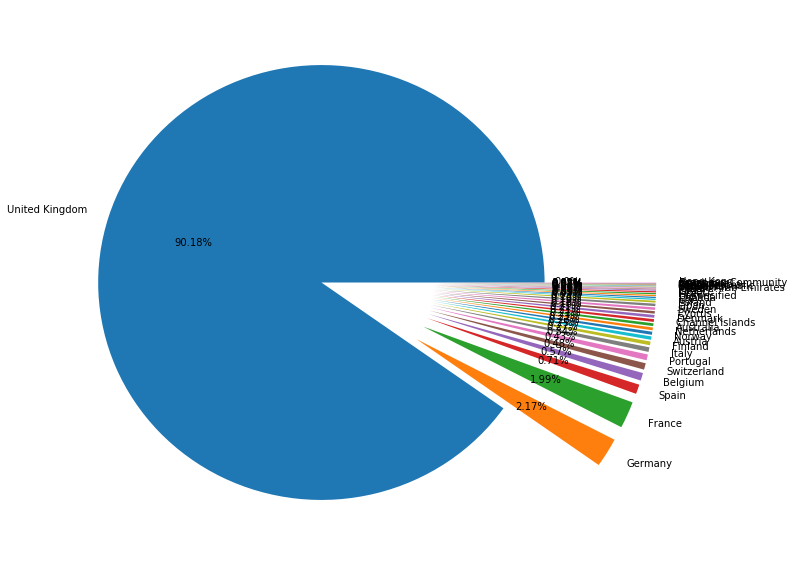

In [8]:
## graph: Customers distribution by countries

customer_country = raw_data[['Country','CustomerID']].drop_duplicates() 
tmp = customer_country.groupby(['Country'])['CustomerID'].aggregate(
    'count').reset_index().sort_values('CustomerID', ascending=False)
liste = [0]
liste.extend([0.5]*37)
fig = plt.figure(figsize = (10,10))
plt.pie(tmp['CustomerID'], labels=tmp['Country'], explode=liste,
        autopct = lambda x: str(round(x, 2)) + '%')
plt.show()

In [9]:
raw_data = step_clean(raw_data)

*step_clean()* function
- Most customers come from UK and we will keep only those customers to avoid any cofounding factor in our customer segmentation
- add a column 'Gross' (= Quantity * UnitPrice) 
- drop lines: customers without ID
- drop lines: not corresponding to an actual purchase of an item (Bank charges etc.)

### A.2. Cancelled purchases

In [10]:
cancelled_list = raw_data['InvoiceNo'].apply(find_cancelled)
cancelled_raw_data = raw_data[cancelled_list]
regular_raw_data = raw_data[cancelled_list==False]

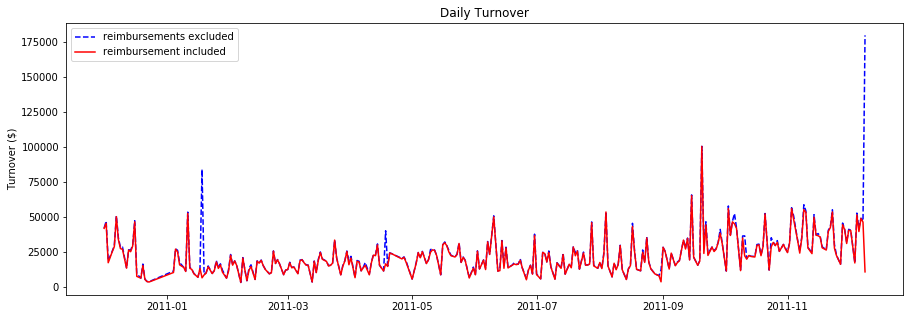

In [11]:
def find_date(data):
    return(data.date())

fig = plt.figure(figsize = (15,5))
plt.plot(regular_raw_data.groupby(regular_raw_data['InvoiceDate'].apply(
    find_date))['Gross'].sum(), color='blue',ls='--',
    label='reimbursements excluded')
plt.plot(raw_data.groupby(raw_data['InvoiceDate'].apply(
    find_date))['Gross'].sum(),color='red', label='reimbursement included')
plt.title("Daily Turnover")
plt.ylabel("Turnover ($)")
plt.legend()
plt.show()

Reimbursements are included in the initial dataset like regular purchases but with a negative UnitPrice.
If we exclude reimbursements, we can see a few supplementary peaks in the daily turnover, notably near the end of the year. Those peaks correspond to invoices that were ultimately cancelled by the customer(s).

*find_cancel()* function is used to find cancelled invoices (reimbursed purchase) and store them in a specific table

### A.3. Products table

ArticleTable stores some descriptive statistics about products then a PCA is computed to try to find some general features

In [12]:
#3.Article Table
##########################################################################
ArticleTable = regular_raw_data.groupby('StockCode').agg({
    'Quantity': ['min', 'max', 'mean', 'sum'],
    'UnitPrice': ['min', 'max', lambda x: x.mode().min()],                                                           
    'Gross': ['min', 'max', 'mean', 'sum'],
    'InvoiceNo': lambda x: x.nunique(),
    'CustomerID': lambda x: x.nunique()
})
ArticleTable.columns = ['QTYmin', 'QTYmax', 'QTYmean', 'QTYsum', 'UPmin',
                        'UPmax', 'UPmode', 'GROSSmin', 'GROSSmax',
                        'GROSSmean', 'GROSSsum', 'InvoiceNb', 'CustomerNb']

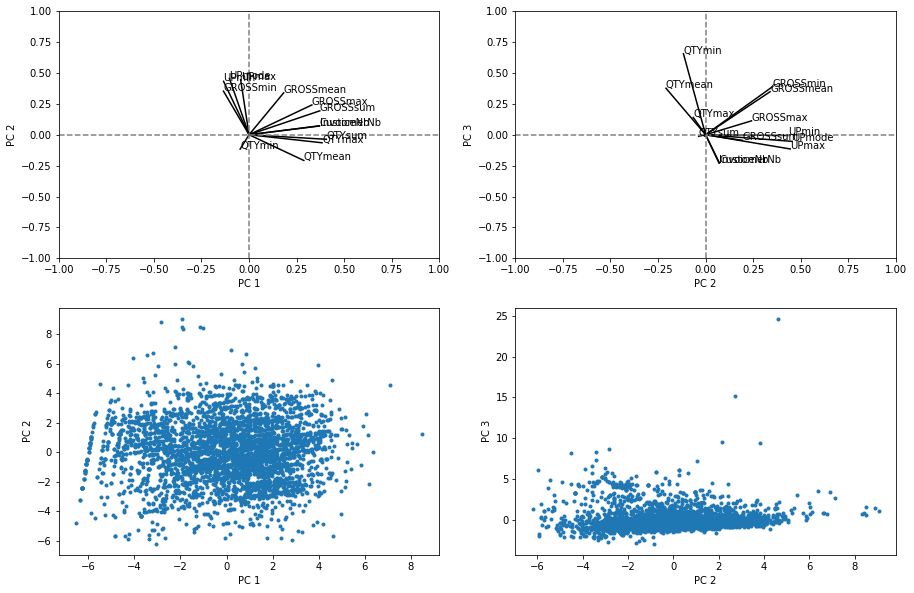

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # create scaler object
ArticleTable_scaled = scaler.fit_transform(np.log(ArticleTable+0.01))   

from sklearn.decomposition import PCA   
pca = PCA(n_components=5)
result = pca.fit_transform(ArticleTable_scaled)

from predefined_plot import plot_article_pca
plot_article_pca(pca, result, ArticleTable)

In [14]:
ArticleCharacteritics = pd.DataFrame(
    result[:,:2], index=ArticleTable.index, columns=['ARTpop', 'ARTcost'])

The first two dimensions are kept to encapsulate the 'popularity' and the 'cost' features of the products

`ArticleCharacteritics.to_csv('ArticleCharacteritics.csv')`

Then, for each line (one purchase of a product) in the dataset, we add the corresponding value of those two features describing products

In [15]:
regular_raw_data2 = regular_raw_data.copy()

liste = regular_raw_data2['StockCode']
tmp = ArticleCharacteritics.loc[liste,:].reset_index()
regular_raw_data2 = regular_raw_data2.reset_index()
regular_raw_data2.loc[:,'ARTpop'] = tmp.loc[:,'ARTpop'] 
regular_raw_data2.loc[:,'ARTcost'] = tmp.loc[:,'ARTcost']

regular_raw_data2.index = regular_raw_data2['index']
regular_raw_data2 = regular_raw_data2.drop(columns=['index'])

### A.4. Average Basket

*MeanBasket()* function computes some summary statistics on data aggregated by invoice which are then aggregated by customer to assess the 'average basket'

- MB_TotValue: average value of the basket
- MB_NbArt, MB_NbUnArt: average number of product and different products of a basket
- MB_PUmin, MB_PUmax, MB_PUmean: min, max and mean of the unit prices of the products
- MB_ARTpop, MB_ARTcost: mean values of the scores (from the PCA) describing the products
- MB_Diversity, MB_Evenness: Diversity (Shannon index)shows how diverse is the basket (integrates the number of different items and also the quantity of each item); Evenness shows how much even is the distribution of items in the basket (eg maximum value of 1 for a basket with evenly distributed quantities of items)

In [16]:
MeanBasketTable = Mean_Basket(regular_raw_data2)
MeanBasketTable.head()

,MB_TotValue,MB_NbArt,MB_Diversity,MB_NbUnArt,MB_PUmin,MB_PUmax,MB_PUmean,MB_ARTpop,MB_ARTcost,MB_Evenness
CustomerID,,,,,,,,,,
12346.0,77183.600000,74215.000000,0.000000,1.000000,1.040000,1.040000,1.040000,8.484103,1.245166,0.000000
12747.0,381.455455,115.909091,1.924314,9.363636,1.474545,9.386364,4.253949,3.025023,2.059023,0.882163
12748.0,156.880194,123.839806,2.026504,22.233010,1.107816,7.897379,2.728170,1.896364,0.260252,0.752862
12749.0,808.176000,294.000000,2.846252,39.600000,1.512000,11.070000,4.812586,2.608618,2.144592,0.745271
12820.0,235.585000,180.500000,2.503891,14.750000,0.487500,4.450000,1.902633,3.034532,0.276353,0.943213


### A.5. Customer table

- *set_CustomerFeatures()* function computes similar statistics as *Mean_Basket()* but this time without aggregation by basket
- The RFM metrics (Recency: numbers of days since last purchase, Frequency: number of invoices, Monetary: total money spent) are computed by *set_rfm()* function

Those 2 tables are concatened with the Average Basket table

- CancelledTable stores the cancelled invoices (negative monetary values = reimbursements)

In [17]:
rfmTable = set_rfm(regular_raw_data2)
CustomerTable = set_CustomerFeatures(regular_raw_data2)
CancelledTable = set_CancelledTable(cancelled_raw_data)
CustomerTable = pd.concat([rfmTable, CustomerTable, MeanBasketTable],
                       axis=1)
display(CustomerTable.head())

,recency,frequency,monetary_value,NbArt,Diversity,NbUnArt,PUmin,PUmax,PUmean,Evenness,...,MB_TotValue,MB_NbArt,MB_Diversity,MB_NbUnArt,MB_PUmin,MB_PUmax,MB_PUmean,MB_ARTpop,MB_ARTcost,MB_Evenness
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,326,1,77183.60,74215,-0.000000,1,1.04,1.04,1.040000,0.000000,...,77183.600000,74215.000000,0.000000,1.000000,1.040000,1.040000,1.040000,8.484103,1.245166,0.000000
12747.0,3,11,4196.01,1275,4.340231,42,0.85,15.95,4.367864,1.161213,...,381.455455,115.909091,1.924314,9.363636,1.474545,9.386364,4.253949,3.025023,2.059023,0.882163
12748.0,1,206,32317.32,25511,7.210532,1766,0.04,29.95,2.375596,0.964430,...,156.880194,123.839806,2.026504,22.233010,1.107816,7.897379,2.728170,1.896364,0.260252,0.752862
12749.0,4,5,4040.88,1470,4.938654,159,0.39,14.95,4.772677,0.974304,...,808.176000,294.000000,2.846252,39.600000,1.512000,11.070000,4.812586,2.608618,2.144592,0.745271
12820.0,4,4,942.34,722,3.905482,55,0.29,4.95,1.904746,0.974584,...,235.585000,180.500000,2.503891,14.750000,0.487500,4.450000,1.902633,3.034532,0.276353,0.943213


### A.6. Final table

Finally, the table with cancelled invoices statistics (aggregated by customer) is merged with the customer table (summary statistics for cancelled invoices *set_CancelledTable()*) and a few supplementary features are added like the net amount of money spent by a customer or his rate of invoice cancellation

We end up with 29 features in our FinalTable (some features being most likely partially redundant)

In [18]:
FinalTable.head()

,recency,frequency,monetary_value,NbArt,Diversity,NbUnArt,PUmin,PUmax,PUmean,Evenness,...,MB_ARTpop,MB_ARTcost,MB_Evenness,C_NbArt,C_NbInvoice,C_monetary,net_frequency,net_monetary,C_Art_ratio,C_Inv_ratio
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,326,1,77183.60,74215,-0.000000,1,1.04,1.04,1.040000,0.000000,...,8.484103,1.245166,0.000000,74215.0,1.0,77183.60,0.0,0.00,1.00000,1.000000
12747.0,3,11,4196.01,1275,4.340231,42,0.85,15.95,4.367864,1.161213,...,3.025023,2.059023,0.882163,-0.0,0.0,-0.00,11.0,4196.01,-0.00000,0.000000
12748.0,1,206,32317.32,25511,7.210532,1766,0.04,29.95,2.375596,0.964430,...,1.896364,0.260252,0.752862,1535.0,42.0,1830.79,164.0,30486.53,0.06017,0.203883
12820.0,4,4,942.34,722,3.905482,55,0.29,4.95,1.904746,0.974584,...,3.034532,0.276353,0.943213,-0.0,0.0,-0.00,4.0,942.34,-0.00000,0.000000
12821.0,215,1,92.72,70,1.623470,6,0.65,8.50,2.498333,0.906076,...,2.098819,0.233062,0.906076,-0.0,0.0,-0.00,1.0,92.72,-0.00000,0.000000


### A few observations

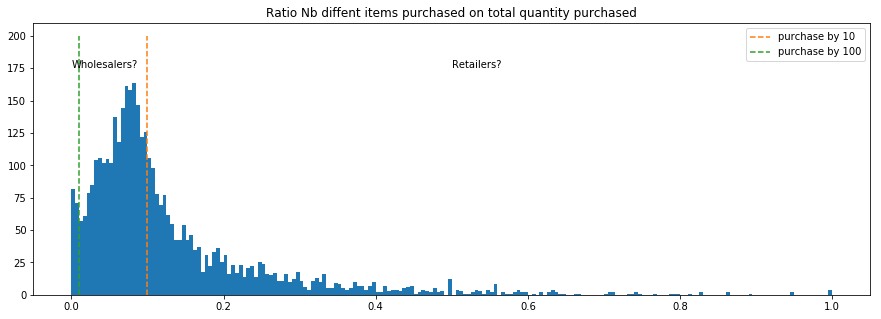

In [19]:
fig = plt.figure(figsize=(15,5))

plt.hist(CustomerTable['NbUnArt']/CustomerTable['NbArt'],bins=200)
plt.plot([0.1,0.1],[0,200],ls='--', label='purchase by 10')
plt.plot([0.01,0.01],[0,200],ls='--', label='purchase by 100')
plt.text(0,175,'Wholesalers?')
plt.text(0.5,175,'Retailers?')
plt.title('Ratio Nb diffent items purchased on total quantity purchased')
plt.legend()
plt.show()

Some customers tend to purchase a given product in large quantities. This suggests that some of our customers are more likely wholesalers. 

The features 'BulkPurchase' and 'p_wholesalers' are based on the ratio Nb different items on Nb total items to encapsulate this information

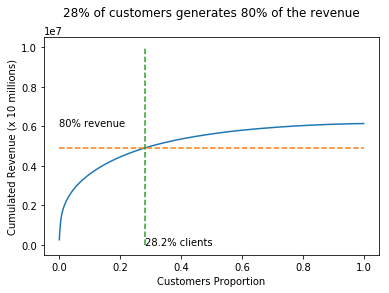

In [20]:
tmp = FinalTable.sort_values('net_monetary',ascending=False)['net_monetary']
CumulRevenue = pd.DataFrame({
    'cumul': tmp.cumsum(), 'p_cust': (np.arange(1,tmp.shape[0]+1))/tmp.shape[0]
})
CumulRevenue = CumulRevenue.reset_index()

maxrev = np.max(CumulRevenue['cumul'])
idx = max(CumulRevenue[CumulRevenue['cumul']<=0.8*maxrev].index)

plt.plot(CumulRevenue['p_cust'],CumulRevenue['cumul'])
plt.plot([0,1],[0.8*maxrev,0.8*maxrev],ls='--')
plt.plot([CumulRevenue.loc[idx,'p_cust'],CumulRevenue.loc[idx,'p_cust']],[0,10000000],ls='--')
message="{}% clients".format(round(CumulRevenue.loc[idx,'p_cust']*100,2))
plt.text(CumulRevenue.loc[idx,'p_cust'],0.2, message)
plt.text(0,6*10**6,"80% revenue")
plt.title('28% of customers generates 80% of the revenue\n')
plt.ylabel('Cumulated Revenue (x 10 millions)')
plt.xlabel('Customers Proportion')
plt.show()

In accordance with the law of Pareto, we can see that a small fraction of the customers generates most of the revenues.

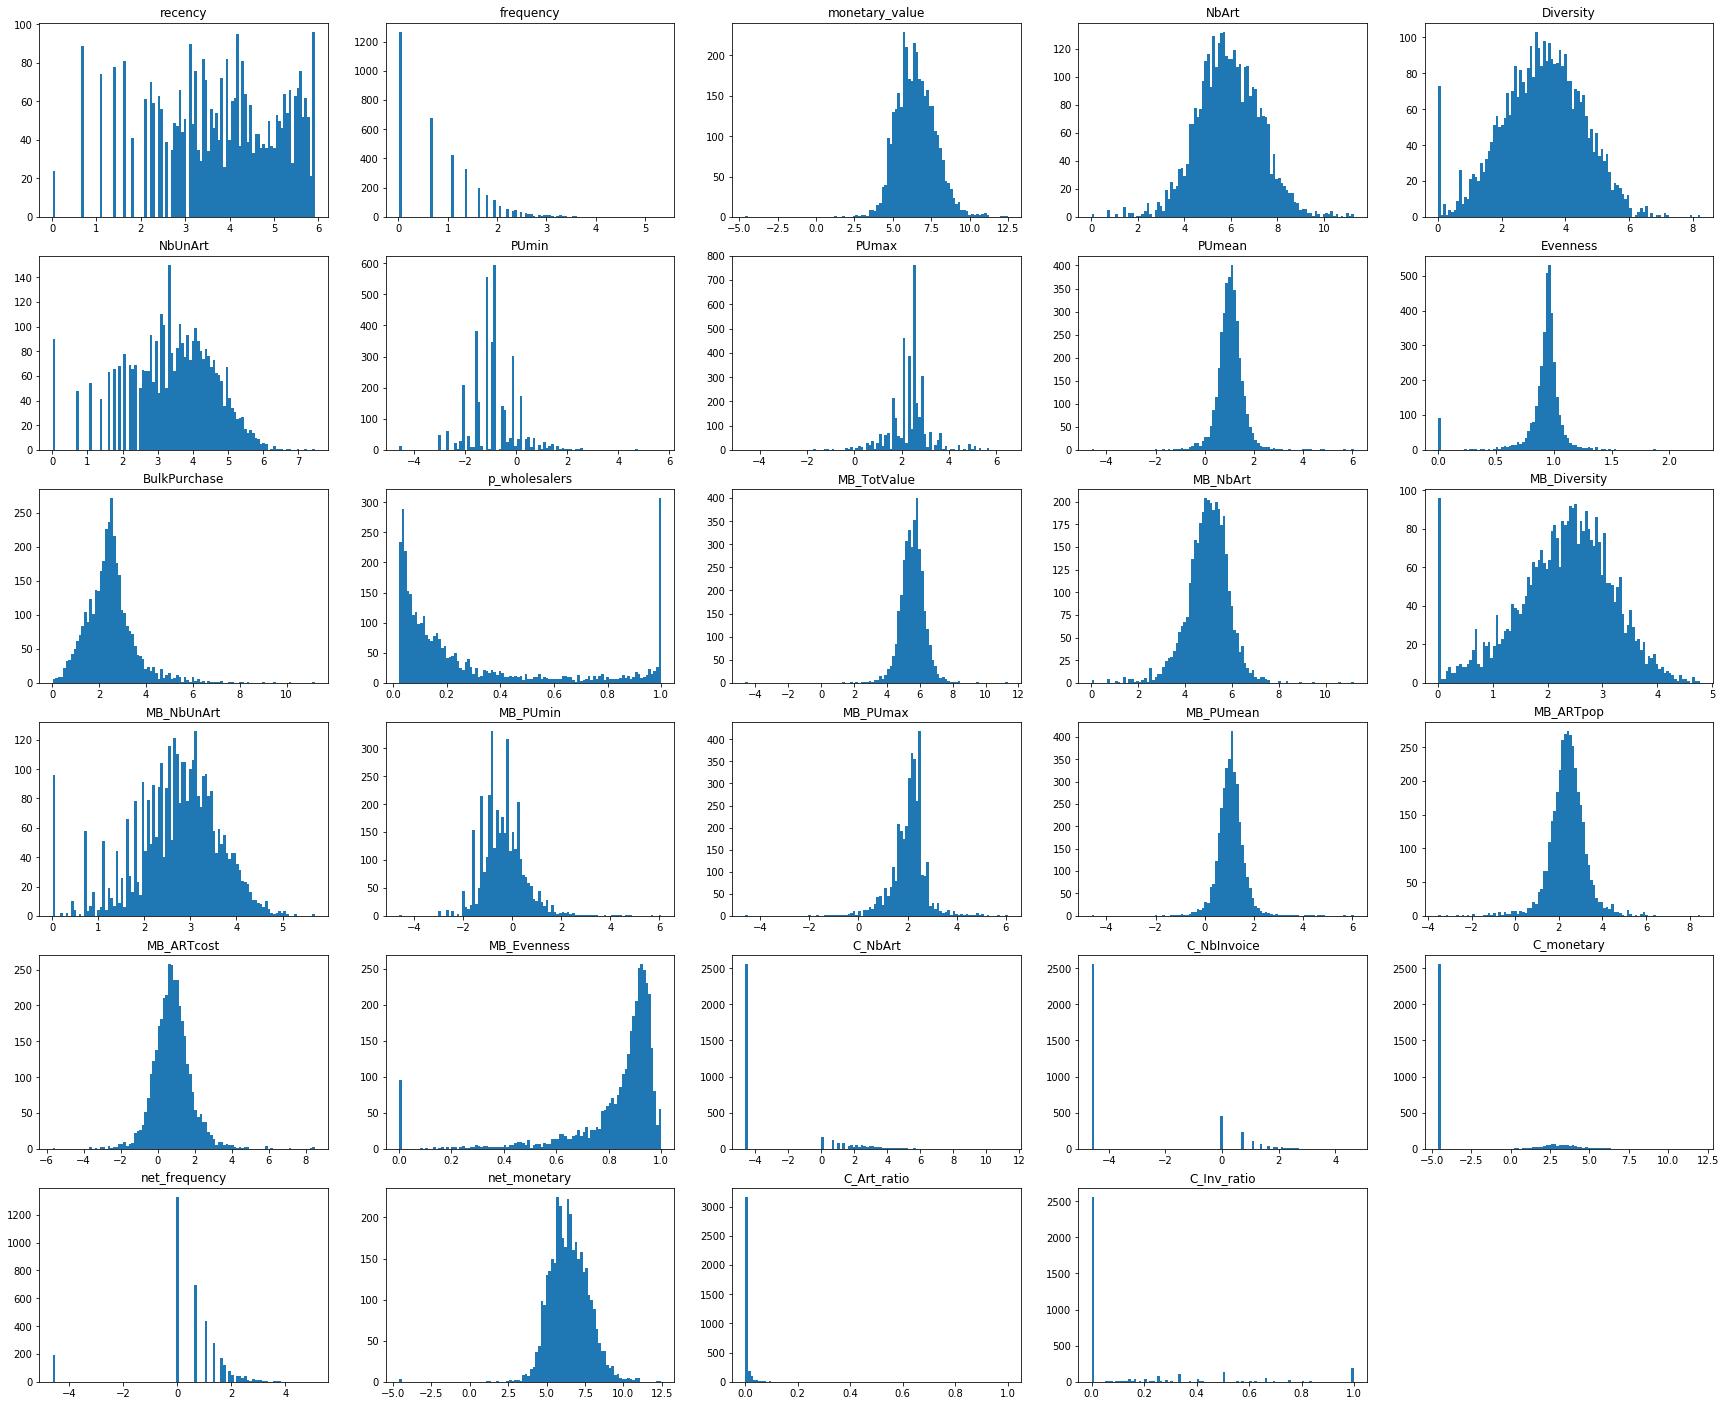

In [4]:
Scaled_CustomerTable = FinalTable.copy()
# log-scaling every variables except variables already in [0,1] range

for i in [0,1,2,3, #not 4
          5,6,7,8, # not 9
          10,12,13, #not 11, 14
          15, 16,17,18, # not 19
          22,23,24, #not 20,21
          25,26 #not 27,28
          ]:          
    Scaled_CustomerTable.iloc[:,i] = np.log(
        Scaled_CustomerTable.iloc[:,i]+0.01)

## vizualisations all features after scaling 
i = 1
plt.figure(figsize=(30,25))
for col in Scaled_CustomerTable.columns:
    plt.subplot(6,5,i)
    plt.hist(Scaled_CustomerTable[col],bins=100)
    plt.title(col)
    i+=1
plt.show()

Finally, due to the wide variations in the values of the different features, a log-scaling is applied

In [5]:
# date saves:
ArticleCharacteritics.to_csv('ArticleCharacteritics.csv')
FinalTable.to_csv('CustomerTable_fin.csv')
Scaled_CustomerTable.to_csv('Scaled_CustomerTable.csv')

# B. Customer segmentation: unsupervised classification

We will first try to reduce the number of features with a PCA then we'll look for a satisfying clustering with
- clusters well-defined in the feature space
- clusters with a comprehensive signification

In [6]:
FinalTable = pd.read_csv('CustomerTable_fin.csv',index_col=0)
## Scaled_CustomerTable = transfo log des valeurs
Scaled_CustomerTable = pd.read_csv('Scaled_CustomerTable.csv',index_col=0)

# Dimensionality reduction: PCA

The first step is to perform a PCA and keep the first, most informative, dimensions

In [7]:
## standard scaling: 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # create scaler object
scaler.fit(Scaled_CustomerTable)   
Scaled_CustomerTable = pd.DataFrame(scaler.transform(Scaled_CustomerTable),
                                   index= Scaled_CustomerTable.index,
                                   columns= Scaled_CustomerTable.columns)

In [8]:
from sklearn.decomposition import PCA   
pca = PCA(n_components=8)
result = pca.fit_transform(Scaled_CustomerTable)
print('Cumulated explained variance :\n',
      pca.explained_variance_ratio_.cumsum())

Cumulated explained variance :
 [0.29523771 0.47607807 0.64858648 0.74282245 0.80680634 0.85162328
 0.88045358 0.90458611]


In [9]:
pcaPC = pd.DataFrame(pca.components_.T,index=Scaled_CustomerTable.columns,
                    columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'])
display(pcaPC.head())

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
recency,0.184728,-0.023060,-0.051592,0.110466,0.255899,-0.058581,-0.083031,0.045461
frequency,-0.257396,0.017448,0.167448,-0.160341,-0.303169,0.027936,0.024565,-0.021058
monetary_value,-0.303636,0.009850,0.130537,-0.169114,0.100024,0.000335,0.052149,0.004485
NbArt,-0.311777,0.129214,0.024553,-0.120440,0.061050,0.080279,-0.010743,0.015270
Diversity,-0.302871,-0.122378,-0.088500,-0.043242,-0.138104,-0.031376,0.094226,-0.094379


The first 8 components explain ~90% of the variance of the initial dataset. With the first 4, we reach already 75% of explained variance.

# Data visualization

In [10]:
import seaborn as sns

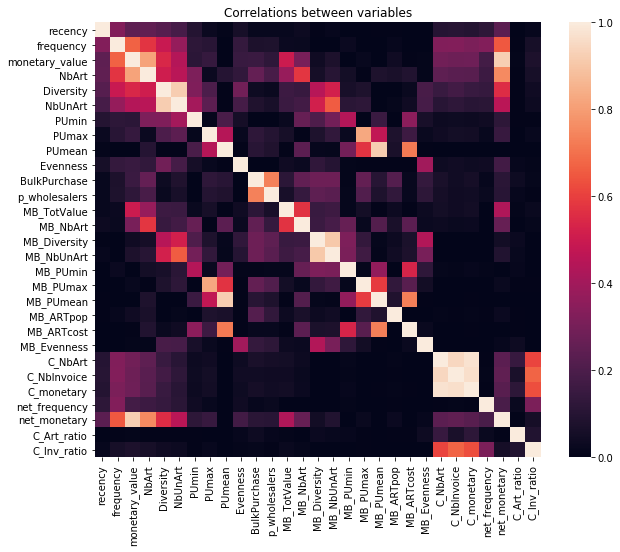

In [11]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(Scaled_CustomerTable.corr(method='pearson')**2, vmin=0, vmax=1)
plt.title('Correlations between variables')
plt.show()

Some groups of variables are correlated, e.g. metrics R,F,M + NbARt, NbUnArt, Diversity 

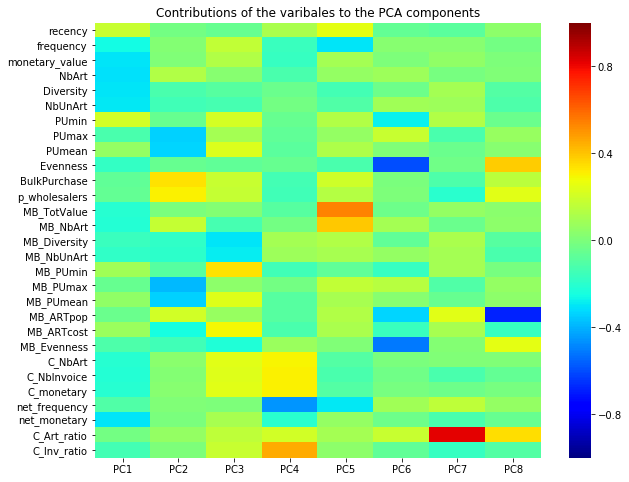

In [12]:
fig = plt.figure(figsize=(10,8))
sns.heatmap((pcaPC), vmin=-1, vmax=1, cmap='jet')
plt.title('Contributions of the varibales to the PCA components')
plt.show()

The first dimensions are characterized by contributions of several of the inital features while the last dimensions tend to be more affected by one or few features

# Unsupervised clustering: Optimal clustering

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from utils import plot_bar, silh_score, multi_score

In [14]:
loss, silh = multi_score(dat=result,cmin=2,cmax=10)

*multi_score()* fit several Kmeans models for a number of clusters ranging from cmin to cmax and returns the score for loss and silhouette index (an index assessing the quality of the clusters)

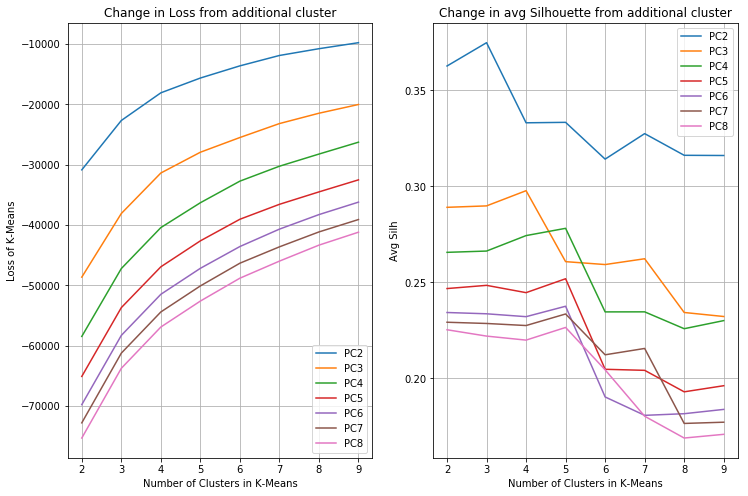

In [15]:
from predefined_plot import plot_km_scores
plot_km_scores(loss, silh)

The quality of the cluster (assessed by the silhouette index) improved when the number of components used is decreased from 8 to 4. The optimal number of clusters is always 5 in these situations.

This observation changes when the number of components used is below 4, but then the % of initial information retained becomes low and that's not desirable

We will run the classification with the dataset composed of the first 4 components and with 5 clusters.

# Cluster definition

In [16]:
def plot_bar_explo(dat,cluster_labels, barwidth=0.1):
    """convenient plotting function"""

    plt.figure(figsize = (dat.shape[1]*2,5))
    ncluster = pd.Series(cluster_labels).value_counts()
    for i in range(dat.shape[1]):
        bars = dat.iloc[:,i]
        rx = np.arange(len(bars))+i*barwidth
        plt.bar(rx,bars, width=barwidth, edgecolor='black')
    for j in ncluster.index:
        plt.text(j+0.5,-1.3,'n='+str(ncluster[j]))

    plt.xlim(-0.5,dat.shape[0]+1)
    plt.ylim(-1.5,1.5)
    plt.legend(dat.columns, loc='upper right')
    plt.show()

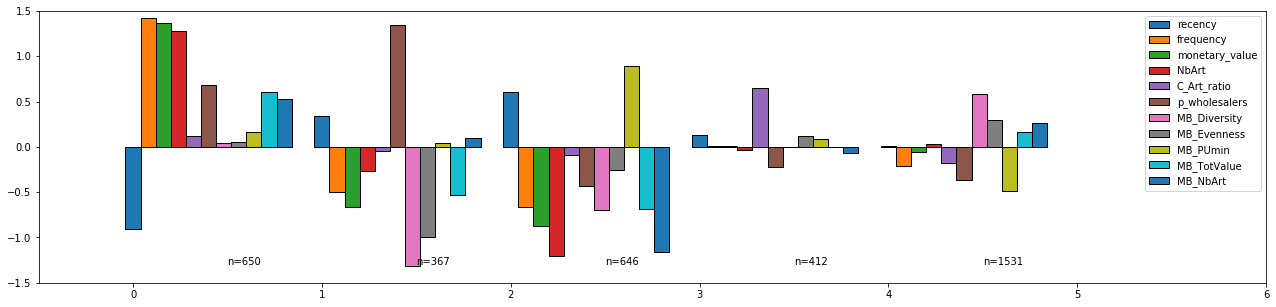

In [17]:
kmeans = KMeans(5, random_state=10)
cluster_labels5 = kmeans.fit_predict(result[:,:4])
ScaledCustomerSummary = Scaled_CustomerTable.groupby(cluster_labels5).mean()
dat = ScaledCustomerSummary[['recency','frequency','monetary_value',
                       'NbArt','C_Art_ratio','p_wholesalers',
                        'MB_Diversity', 'MB_Evenness', 'MB_PUmin','MB_TotValue','MB_NbArt'    ]]
plot_bar_explo(dat,cluster_labels5, barwidth=0.08)

If we look at the mean values of some selected features for each cluster we can draw a profile of the clusters. The variables were scaled therefore we are only interested in the comparison among group (not the values themselves)

For instance, the first cluster is characterized by better than average values for the RFM metrics (Recency is measured by the number of days since last purchase therefore  a low value for Recency is desirable) and those customers are likely the most loyal customers. Those customers also tend to be wholesalers (high 'wholersalers' variable).

Based on these profiles we can try to name the different clusters of customers

### Let's name the clusters...

In [18]:
df_cluster_labels5 = pd.DataFrame(cluster_labels5, index= FinalTable.index, columns=['Gpe'])
def set_label_names(dat):
    if dat==0:
        return('Wholesal_loyal')
    elif dat==1:
        return('Wholesal_occas')
    elif dat==2:
        return('Retail_specific')
    elif dat==3:
        return('Retail_tester')
    else:
        return('Retail_general')
df_cluster_labels5['label_names'] = df_cluster_labels5['Gpe'].apply(
    set_label_names)
df_cluster_labels5.head()

,Gpe,label_names
CustomerID,,
12346.0,1,Wholesal_occas
12747.0,0,Wholesal_loyal
12748.0,0,Wholesal_loyal
12820.0,4,Retail_general
12821.0,2,Retail_specific


In [19]:
from joblib import dump
dump(kmeans,'KmeansModel_5gp_fin.pkl')
dump(df_cluster_labels5,'df_labels_fin.pkl')

['df_labels_fin.pkl']

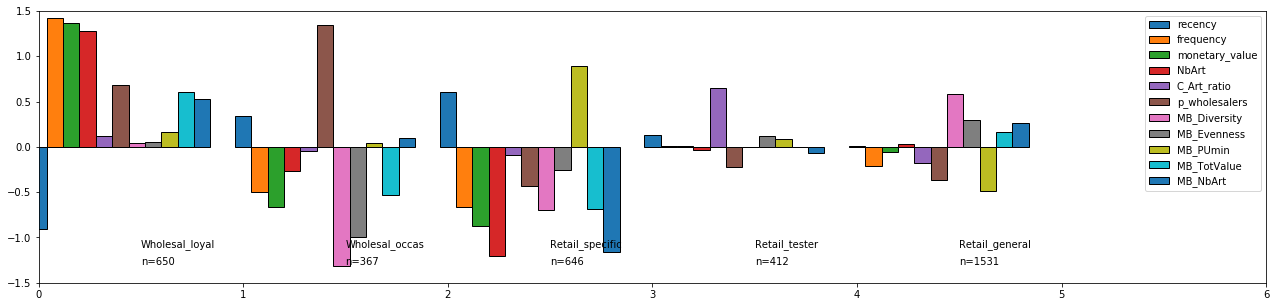

In [20]:
ScaledCustomerSummary = Scaled_CustomerTable.groupby(
    df_cluster_labels5['Gpe']).mean()

dat = ScaledCustomerSummary[['recency','frequency','monetary_value',
                       'NbArt','C_Art_ratio','p_wholesalers',
                        'MB_Diversity', 'MB_Evenness', 'MB_PUmin',
                             'MB_TotValue','MB_NbArt'    ]]


plot_bar(dat,df_cluster_labels5,0.08)

**Wholesalers, loyal : 'Wholesal_loyal'**
Most loyal customers (High RFM) who buy frequently and bring the more money to the shop (high 'MB_TotValue'). They buy in rather large quantities (MB_NbArt, p_wholesalers)

**Wholesalers, occassional: 'Wholesal_occas'**
Wholesalers who buy in large quantities only some type of products (low diversity of baskets). RFM metrics are worse than average, they aren't loyal customers but rather occasional customers

**Retailers, specific: 'Retail_specific'**
These customers have worse than average values for most metrics except for the min value of a product in the basket which is high. They don't in large quantities, their baskets aren't diverse, they buy occasionnally, but when they buy they can buy expensive product. For me that evokes a customer who came specifically to the online shop to find the precise product they were looking for and who won't necessarily come back.

**Retailers, testers: 'Retail_tester'**
These customers have average values for all metrics except 'p_wholesaler' a bit lower than average and especially 'C_Art_ratio' clearly higher than average. These customer have cancelled a significant fraction of their purchases and this behaviour characterizes them. Maybe they came to the site to test some products and send them back, maybe they are not satisfied with the products or the site.

**Retailers, general: 'Retail_general'**
This cluster is the most populated. With average RFM metrics, this is the most monetary valuable group after the 'Wholesal_loyal' group. Unlike this group, the customers from the 'Retail_general' group buy in small quantities and have very diverse baskets. Most likely, they constitute the core of regular customers.

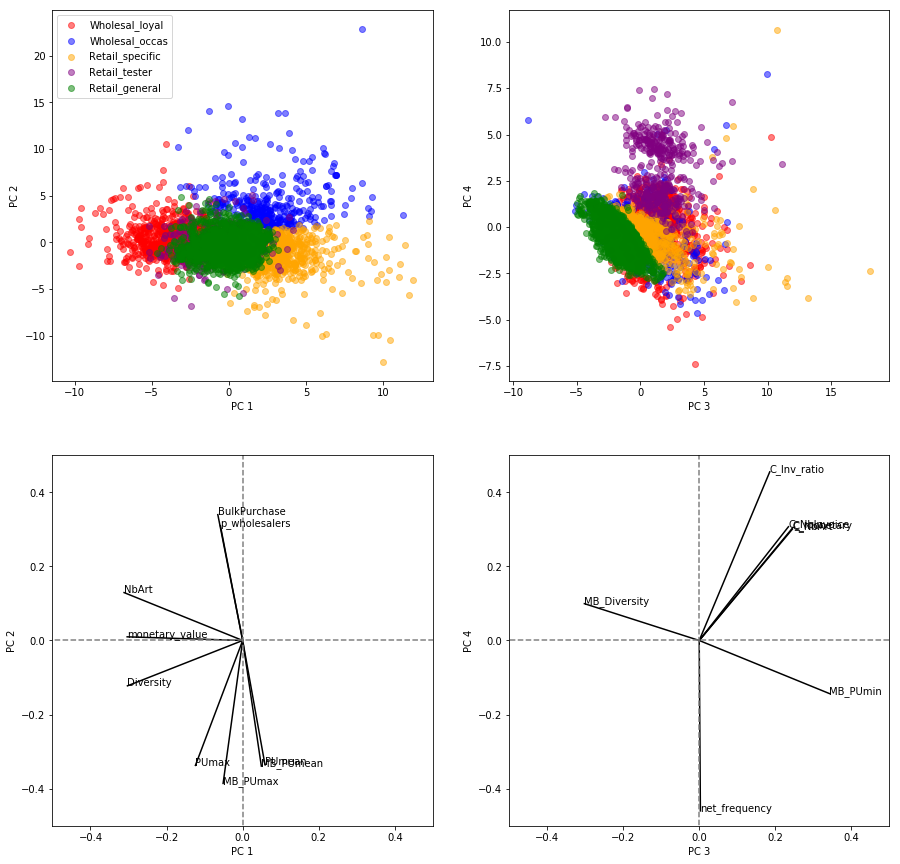

In [35]:
from predefined_plot import plot_customer_pca
plot_customer_pca(pca, result, df_cluster_labels5, FinalTable)

The first PCA axis is characterized on the left by large quantities of products purchased and money spent. It discriminate the 'Wholesal_loyal' (left) from the 'Retail_specific' (right). 'Retail_general' and 'Retail_tester' are central groups.

The second axis display the tendency to buy a few products in large quantity (wholesaler) on the top and discriminates the 'Wholesal_occas'

The third axis tend to place customers with diverse baskets like the 'Retail_general' group on the left

The fourth axis dsicriminate the 'Retail_tester' group on the basis of the cancellation ratio (top)

In [36]:
from utils import RScore, FMScore
rfmTable = FinalTable[['recency','frequency',
                              'monetary_value']].copy()
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

rfmTable['r_quartile'] = rfmTable['recency'].apply(
    RScore, args=('recency',quantiles,))
rfmTable['f_quartile'] = rfmTable['frequency'].apply(
    FMScore, args=('frequency',quantiles,))
rfmTable['m_quartile'] = rfmTable['monetary_value'].apply(
    FMScore, args=('monetary_value',quantiles,))

# Add a new column to combine RFM score: 111 is the highest score as we determined earlier.
rfmTable['RFMScore'] = rfmTable.r_quartile.map(str) +\
    rfmTable.f_quartile.map(str) + rfmTable.m_quartile.map(str)
rfmTable['GP5'] = df_cluster_labels5['label_names']
rfmTable['nb'] = 1
rfmTable.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,GP5,nb
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,4,4,1,441,Wholesal_occas,1
12747.0,3,11,4196.01,1,1,1,111,Wholesal_loyal,1
12748.0,1,206,32317.32,1,1,1,111,Wholesal_loyal,1
12820.0,4,4,942.34,1,2,2,122,Retail_general,1
12821.0,215,1,92.72,4,4,4,444,Retail_specific,1


Recency, Frequency, Monetary (RFM) are commonly used in marketing to assess customers' importance. For each metric we can calculate the quartiles and see how the customers of each groups are ditributed in those quartiles (1 indicates the best quartile from the seller point of view)

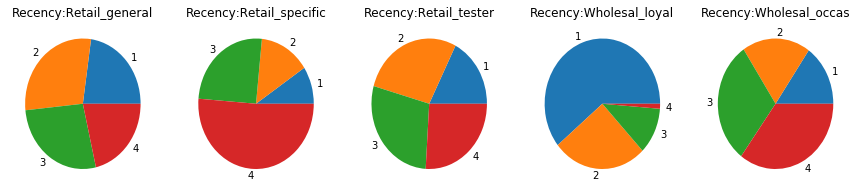

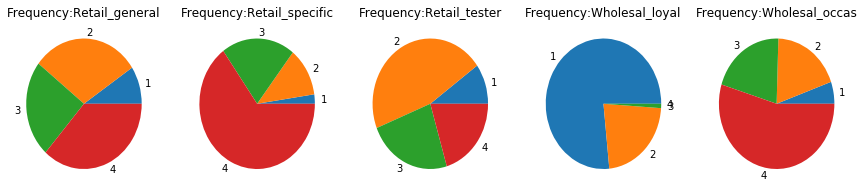

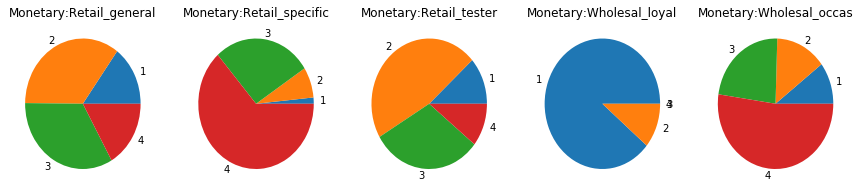

In [37]:
### RFM metrics for every cluster

for col, titl in [['r_quartile','Recency'],['f_quartile','Frequency'],
                  ['m_quartile','Monetary']]:
    table=rfmTable.pivot_table(index=['GP5'], columns=col,values='nb',
                               aggfunc={'nb':np.sum},fill_value=0)
    plt.figure(figsize=(15, 3))
    for i in range(table.shape[0]):
        plt.subplot(1,5,i+1)
        tmp = table.iloc[i,:]
        #plt.figure(figsize=(5, 5))
        plt.pie(tmp,labels=table.columns)
        plt.title(titl+':'+table.index[i])
    plt.show()

'Wholesal_loyal' group contains mostly customers in the first quartiles for RFM metrics and is undoubtly the most valuable group of customers. They are important and must be kept.

'Retail_specific' and 'Wholesal_occas' groups, on the othe hand contain mostly customers in the last quartiles for RFM metrics. We could assume that it isn't worth trying to fidelize them.

'Retail_general' and 'Retail_tester' groups contains customers distributed among all quartiles 'especially in second and third). The group 'Retail_general' in particular is very populated. It is probably worth spending some time to see how to increase engagement of these customers